# Matryoshka Representation Learning (MRL) and Binary Quantization (BQ)

In [2]:
from torch.utils.data import DataLoader
import torch
import math
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample
import logging
import os
import gzip
import csv

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

In [4]:
#### Just some code to print debug information to stdout
logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO, handlers=[LoggingHandler()]
)

# Check if dataset exists. If not, download and extract  it
sts_dataset_path = "../datasets/stsbenchmark.tsv.gz"

Download dataset

In [3]:
if not os.path.exists(sts_dataset_path):
    util.http_get("https://sbert.net/datasets/stsbenchmark.tsv.gz", sts_dataset_path)
else:
    print("File stsbenchmark.tsv already exists")

  0%|          | 0.00/392k [00:00<?, ?B/s]

In [5]:
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model_name

'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'

In [6]:
# Read the dataset
train_batch_size = 16
num_epochs = 4
model_save_path = (
    "../models/matryoshka_sts_" + model_name.split('/')[-1]
)

model_save_path

'../models/matryoshka_sts_paraphrase-multilingual-MiniLM-L12-v2'

Load model

In [7]:
# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for mapping tokens to embeddings
word_embedding_model = models.Transformer(model_name)

In [8]:
# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False,
)

In [9]:
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

2024-04-12 21:20:06 - Use pytorch device_name: cuda


In [10]:
# Convert the dataset to a DataLoader ready for training
logging.info("Read STSbenchmark train dataset")

train_samples = []
dev_samples = []
test_samples = []
with gzip.open(sts_dataset_path, "rt", encoding="utf8") as fIn:
    reader = csv.DictReader(fIn, delimiter="\t", quoting=csv.QUOTE_NONE)
    for row in reader:
        score = float(row["score"]) / 5.0  # Normalize score to range 0 ... 1
        inp_example = InputExample(texts=[row["sentence1"], row["sentence2"]], label=score)

        if row["split"] == "dev":
            dev_samples.append(inp_example)
        elif row["split"] == "test":
            test_samples.append(inp_example)
        else:
            train_samples.append(inp_example)

2024-04-12 21:20:12 - Read STSbenchmark train dataset


In [11]:
print(test_samples[10])

<InputExample> label: 0.3428, texts: A man is playing a guitar.; A man is playing a trumpet.


In [12]:
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_loss = losses.CoSENTLoss(model=model)
train_loss = losses.Matryoshka2dLoss(model, train_loss, [768, 512, 256, 128, 64])

logging.info("Read STSbenchmark dev dataset")
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name="sts-dev")

2024-04-12 21:20:14 - Read STSbenchmark dev dataset


In [13]:
# Configure the training. We skip evaluation in this example
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))

2024-04-12 21:20:15 - Warmup-steps: 144


## Training

In [14]:
# Train the model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=num_epochs,
    evaluation_steps=1000,
    warmup_steps=warmup_steps,
    output_path=model_save_path,
)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2024-04-12 21:21:02 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 0:
2024-04-12 21:21:05 - Cosine-Similarity :	Pearson: 0.8352	Spearman: 0.8666
2024-04-12 21:21:05 - Manhattan-Distance:	Pearson: 0.8633	Spearman: 0.8657
2024-04-12 21:21:05 - Euclidean-Distance:	Pearson: 0.8633	Spearman: 0.8655
2024-04-12 21:21:05 - Dot-Product-Similarity:	Pearson: 0.6230	Spearman: 0.6182
2024-04-12 21:21:05 - Save model to ../models/matryoshka_sts_paraphrase-multilingual-MiniLM-L12-v2


Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2024-04-12 21:21:51 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 1:
2024-04-12 21:21:54 - Cosine-Similarity :	Pearson: 0.8586	Spearman: 0.8802
2024-04-12 21:21:54 - Manhattan-Distance:	Pearson: 0.8708	Spearman: 0.8737
2024-04-12 21:21:54 - Euclidean-Distance:	Pearson: 0.8710	Spearman: 0.8739
2024-04-12 21:21:54 - Dot-Product-Similarity:	Pearson: 0.6623	Spearman: 0.6645
2024-04-12 21:21:54 - Save model to ../models/matryoshka_sts_paraphrase-multilingual-MiniLM-L12-v2


Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2024-04-12 21:22:40 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 2:
2024-04-12 21:22:43 - Cosine-Similarity :	Pearson: 0.8630	Spearman: 0.8796
2024-04-12 21:22:43 - Manhattan-Distance:	Pearson: 0.8737	Spearman: 0.8756
2024-04-12 21:22:43 - Euclidean-Distance:	Pearson: 0.8738	Spearman: 0.8756
2024-04-12 21:22:43 - Dot-Product-Similarity:	Pearson: 0.6693	Spearman: 0.6681


Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2024-04-12 21:23:29 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 3:
2024-04-12 21:23:32 - Cosine-Similarity :	Pearson: 0.8688	Spearman: 0.8841
2024-04-12 21:23:32 - Manhattan-Distance:	Pearson: 0.8752	Spearman: 0.8775
2024-04-12 21:23:32 - Euclidean-Distance:	Pearson: 0.8755	Spearman: 0.8775
2024-04-12 21:23:32 - Dot-Product-Similarity:	Pearson: 0.6915	Spearman: 0.6921
2024-04-12 21:23:32 - Save model to ../models/matryoshka_sts_paraphrase-multilingual-MiniLM-L12-v2


## Load the stored model and evaluate its performance on STS benchmark dataset

In [15]:
model = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name="sts-test")
test_evaluator(model, output_path=model_save_path)

2024-04-12 21:23:42 - Load pretrained SentenceTransformer: ../models/matryoshka_sts_paraphrase-multilingual-MiniLM-L12-v2
2024-04-12 21:23:42 - Use pytorch device_name: cuda
2024-04-12 21:23:43 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2024-04-12 21:23:46 - Cosine-Similarity :	Pearson: 0.8596	Spearman: 0.8688
2024-04-12 21:23:46 - Manhattan-Distance:	Pearson: 0.8626	Spearman: 0.8605
2024-04-12 21:23:46 - Euclidean-Distance:	Pearson: 0.8627	Spearman: 0.8606
2024-04-12 21:23:46 - Dot-Product-Similarity:	Pearson: 0.6614	Spearman: 0.6514


0.8688129301412233

## Push model to huggingface

In [17]:
model_name = model_name if "/" not in model_name else model_name.split("/")[-1]
model_name

'paraphrase-multilingual-MiniLM-L12-v2'

In [19]:
try:
    model.push_to_hub(f"{model_name}-sts-2d-matryoshka")
except Exception:
    logging.error(
        "Error uploading model to the Hugging Face Hub. To upload it manually, you can run "
        f"`huggingface-cli login`, followed by loading the model using `model = SentenceTransformer({model_save_path!r})` "
        f"and saving it using `model.push_to_hub('{model_name}-sts-matryoshka')`."
    )

2024-04-12 21:26:38 - Save model to C:\Users\koray\AppData\Local\Temp\tmp9rfcnphd


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

unigram.json:   0%|          | 0.00/14.8M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

## Load model and test matryoshka dims

In [12]:
m1 = SentenceTransformer(model_save_path)

2024-03-30 15:59:38 - Load pretrained SentenceTransformer: output/2d_matryoshka_sts_distilbert-base-uncased
2024-03-30 15:59:38 - Use pytorch device_name: mps


In [20]:
sentences = [
    "The cat is watching out of the window",
    "They are playing a computer game",
    "Men are playing cricket",
    "A cat is standing at the window watching outside"
]

embeddings = m1.encode(sentences)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
from sentence_transformers import util

result = {}
for matryoshka_dim in [768, 512, 256, 128, 64]:
    embeddings_shrink = embeddings[..., :matryoshka_dim]  # Shrink the embedding dimensions
    similarities = util.cos_sim(embeddings_shrink[0], embeddings_shrink[1:])
    result[matryoshka_dim] = similarities.cpu().detach().numpy()[0]

In [ ]:
import pandas as pd

df = pd.DataFrame(result)

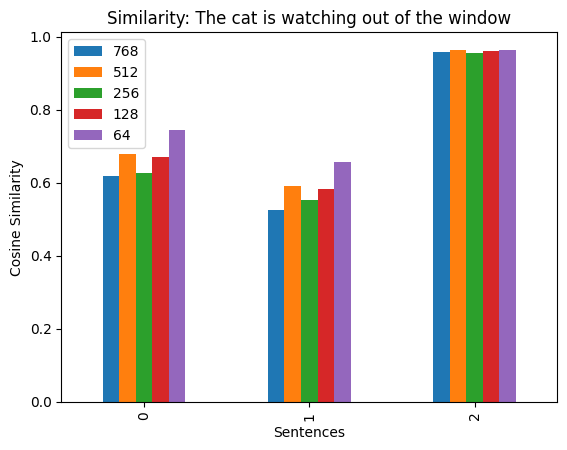

In [23]:
df.plot.bar(ylabel="Cosine Similarity", xlabel="Sentences", title=f"Similarity: {sentences[0]}");

## TODO: Apply Binary Quantization

In [ ]:
m1 = SentenceTransformer(model_save_path)

In [70]:
from sentence_transformers.quantization import quantize_embeddings

sentences = [
    "The cat is watching out of the window",
    "They are playing a computer game",
    "Men are playing cricket",
    "A cat is standing at the window watching outside"
]
binary_embeddings = m1.encode(sentences, precision='binary', convert_to_numpy=False, convert_to_tensor=True, normalize_embeddings=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [89]:
from sentence_transformers import util
from torchmetrics.classification import BinaryHammingDistance, HammingDistance
import torch

result = {}
for matryoshka_dim in [768, 512, 256, 128, 64]:
    embeddings_shrink = binary_embeddings[..., :matryoshka_dim]  # Shrink the embedding dimensions
    metric = HammingDistance(task="multiclass", num_classes=matryoshka_dim)
    
    mess = []
    for m in embeddings_shrink[1:]:
        similarities = metric(embeddings_shrink[0], m)
        mess.append(similarities.item())
    # result[matryoshka_dim] = similarities.cpu().detach().numpy()[0]
    result[matryoshka_dim] = mess

## Calinski Harabasz Score
$CHS(X, L) = \frac{B(X, L) \cdot (n_\text{samples} - n_\text{labels})}{W(X, L) \cdot (n_\text{labels} - 1)}$

where :math: $B(X, L)$ is the between-cluster dispersion, which is the squared distance between the cluster centers
    and the dataset mean, weighted by the size of the clusters, :math: $n_\text{samples}$ is the number of samples,
    :math: $n_\text{labels}$ is the number of labels, and :math: $W(X, L)$ is the within-cluster dispersion e.g. the
    sum of squared distances between each samples and its closest cluster center.
    
PyTorch
```
from torchmetrics.clustering import calinski_harabasz_score
calinski_harabasz_score
```

In [90]:
result

{768: [0.9583333134651184, 0.9791666865348816, 0.6770833730697632],
 512: [0.9583333134651184, 0.9791666865348816, 0.6770833730697632],
 256: [0.9583333134651184, 0.9791666865348816, 0.6770833730697632],
 128: [0.9583333134651184, 0.9791666865348816, 0.6770833730697632],
 64: [0.953125, 0.96875, 0.671875]}

In [57]:
embeddings = m1.encode(["I am driving to the lake.", "It is a beautiful day."])
binary_embeddings = quantize_embeddings(embeddings, precision="binary")
binary_embeddings

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([[  59,  -83,   49,   19,  -63,  -67,   23,  -86,  116,   14,  -40,
          70,  -23, -114,   74,   20,  -85,   13,   69,  -74,  126,   10,
         -95,  -90,  -87,   38,  -55,  -11,  -78, -114,  -78,  106,   -9,
         -92,   76,    9,   -2,  123,   17,  -97,  -23,   79,  -21,   83,
          58,   47,   10,  -15,   -9,   31,   82,  120,   93,  -76,  115,
           1,  100,  -14,  127,  -22,  -80,  -95,   80,   25, -108,   25,
         -61,    2,   17, -105,    6,  -92,   96,  -92,  -39,  -40,  -62,
         117, -106,  -52,   -8,  -86,   41, -120,  -88,  100,  -62,   32,
          -5,   -5,   -2,  -48,  -48,   46,  -29,  -87],
       [  43, -115,   49,   26,  -59,  -91,   19, -112,   96,   64,   -8,
         -58,  -53,   46,   90,   53,   59,   23,   38,  -91,  119,  -39,
          83,   41, -119,   71,  -51,    5,   32,  116,  -78,   12,  -13,
          -3,   67,   75, -102,   10,  -26,  -70,   99,   58,  -17,   47,
          63, -116,  108,  -32,  -93,   51,   90,  -12,

In [93]:
binary_embeddings[0]

tensor([  11, -123,   16, -101, -123,  -80,   17,  -77,  -28,  -98,   72,  -58,
        -101,    4,   26,   56,   59,   29,   22, -124,   49,   -8,   33,   96,
         -63,   53,  -57, -111,  -82,    6,  -77,   40,   -2,  -92,  102,   26,
         -71,  -18,  -58,  -78,   97, -100,  -57,  127,  -83,  -19,  -40,  105,
         -89, -110,  123,   60,   75,   85, -104,   43,  -14,   78,   93,  121,
          85,   70,   17,  -28,   -4,  -69,  -61,   60, -112,  -25,   94, -111,
         -21, -106,   90,   30,  -16,  -59, -100,  -97,   70,   78,   -5,   20,
         -22,  123,   68,  -77,  105,   21,  -71,    3,   72,  111,    8,  -69],
       dtype=torch.int8)

In [95]:
embeddings

array([[ 0.5170344 , -0.11213418,  0.4357653 , ..., -0.37049708,
        -0.02676672,  0.10248528],
       [ 0.5183879 , -0.25044525,  0.06931788, ..., -0.0939942 ,
         0.30613455, -0.17210767]], dtype=float32)

In [110]:
import numpy as np

# np.packbits(embeddings > 0).reshape(embeddings.shape[0], -1)
(np.packbits(embeddings > 0, axis=-1).reshape(embeddings.shape[0], -1) - 128).astype(np.int8)

array([[  59,  -83,   49,   19,  -63,  -67,   23,  -86,  116,   14,  -40,
          70,  -23, -114,   74,   20,  -85,   13,   69,  -74,  126,   10,
         -95,  -90,  -87,   38,  -55,  -11,  -78, -114,  -78,  106,   -9,
         -92,   76,    9,   -2,  123,   17,  -97,  -23,   79,  -21,   83,
          58,   47,   10,  -15,   -9,   31,   82,  120,   93,  -76,  115,
           1,  100,  -14,  127,  -22,  -80,  -95,   80,   25, -108,   25,
         -61,    2,   17, -105,    6,  -92,   96,  -92,  -39,  -40,  -62,
         117, -106,  -52,   -8,  -86,   41, -120,  -88,  100,  -62,   32,
          -5,   -5,   -2,  -48,  -48,   46,  -29,  -87],
       [  43, -115,   49,   26,  -59,  -91,   19, -112,   96,   64,   -8,
         -58,  -53,   46,   90,   53,   59,   23,   38,  -91,  119,  -39,
          83,   41, -119,   71,  -51,    5,   32,  116,  -78,   12,  -13,
          -3,   67,   75, -102,   10,  -26,  -70,   99,   58,  -17,   47,
          63, -116,  108,  -32,  -93,   51,   90,  -12,

In [109]:
(embeddings > 0).astype(int)

array([[1, 0, 1, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 1, 0]])